In [5]:
from instrument_classes import EuropeanBasketCallOption
import datetime

# === Step 1: Inputs ===
tickers = {
    "BHP": "BHP.AX",
    "CSL": "CSL.AX",
    "WDS": "WDS.AX",
    "MQG": "MQG.AX"
}

spot_prices = [39.72, 241.82, 21.92, 207.35]
volatilities = [0.21064992905, 0.2108931923, 0.2676087761, 0.213292141]
weights = [0.10, 0.35, 0.15, 0.40]
correlation_matrix = [
    [1.00, 0.629, 0.569, 0.632],
    [0.629, 1.00, 0.080, 0.498],
    [0.569, 0.080, 1.00, 0.770],
    [0.632, 0.498, 0.770, 1.00]
]
strike_price = 175.00
risk_free_rate = 0.041
date_start = datetime.date(2025, 5, 16)
date_end = datetime.date(2025, 7, 17)
time_to_maturity = (date_end - date_start).days / 365

# === Step 2: Instantiate and Run ===
basket_option = EuropeanBasketCallOption(
    spot_prices, volatilities, correlation_matrix, weights,
    strike_price, time_to_maturity, risk_free_rate
)

option_price, ci_low, ci_high = basket_option.simulate_payoff()

# === Step 3: Output ===
print("\nSpot Prices and Volatilities:")
for name, price, vol in zip(tickers.keys(), spot_prices, volatilities):
    print(f"{name}: Price = ${price:.2f}, Volatility = {vol:.2%}")

print(f"\nEstimated European Basket Call Option Price: ${option_price:.2f}")
print(f"95% Confidence Interval: ${ci_low:.2f} to ${ci_high:.2f}")



Spot Prices and Volatilities:
BHP: Price = $39.72, Volatility = 21.06%
CSL: Price = $241.82, Volatility = 21.09%
WDS: Price = $21.92, Volatility = 26.76%
MQG: Price = $207.35, Volatility = 21.33%

Estimated European Basket Call Option Price: $5.74
95% Confidence Interval: $5.69 to $5.79


# Create graph showing Monte Carlo simulations. 

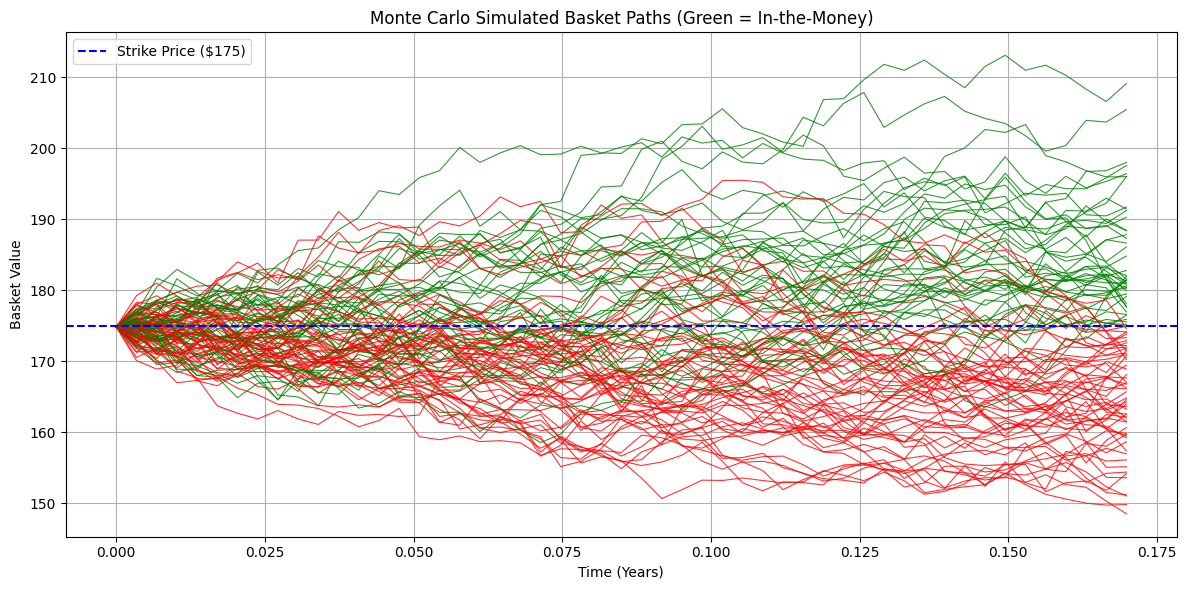

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# === Inputs ===
spot_prices = np.array([39.72, 241.82, 21.92, 207.35])
volatilities = np.array([0.21065, 0.21089, 0.26761, 0.21329])
correlation_matrix = np.array([
    [1.00, 0.629, 0.569, 0.632],
    [0.629, 1.00, 0.080, 0.498],
    [0.569, 0.080, 1.00, 0.770],
    [0.632, 0.498, 0.770, 1.00]
])
weights = np.array([0.10, 0.35, 0.15, 0.40])
r = 0.041
T = 62 / 365  # ~0.1699 years
n_steps = 50
n_paths = 100
strike_price = 175

# === Setup ===
dt = T / n_steps
n_assets = len(spot_prices)
cholesky = np.linalg.cholesky(correlation_matrix)

# === Storage for basket paths ===
basket_paths = np.zeros((n_paths, n_steps + 1))
basket_paths[:, 0] = np.dot(spot_prices, weights)

# === Simulate asset and basket paths ===
current_spots = np.tile(spot_prices, (n_paths, 1))  # shape: (n_paths, n_assets)

for t in range(1, n_steps + 1):
    Z = np.random.normal(size=(n_paths, n_assets))
    correlated_Z = Z @ cholesky.T

    drift = (r - 0.5 * volatilities**2) * dt
    diffusion = volatilities * np.sqrt(dt)

    # Update asset prices for each path
    current_spots *= np.exp(drift + diffusion * correlated_Z)

    # Compute basket value per path
    basket_values = np.dot(current_spots, weights)
    basket_paths[:, t] = basket_values

# === Plotting ===
plt.figure(figsize=(12, 6))
time_grid = np.linspace(0, T, n_steps + 1)

# Color-code paths
for i in range(n_paths):
    final_value = basket_paths[i, -1]
    color = 'green' if final_value > strike_price else 'red'
    plt.plot(time_grid, basket_paths[i], lw=0.8, alpha=0.8, color=color)

# Reference line for strike
plt.axhline(y=strike_price, color='blue', linestyle='--', label="Strike Price ($175)")

plt.title("Monte Carlo Simulated Basket Paths (Green = In-the-Money)")
plt.xlabel("Time (Years)")
plt.ylabel("Basket Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
